<a href="https://colab.research.google.com/github/martin-fabbri/kaggle-competitions/blob/main/cdp-unlocking-climate-solutions/1_kaggle_cdp_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

Install Basemap

In [25]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756177 sha256=a2a8d721e7c3d857951faee06f012be61aaa9ff7bc94d64e9b014949589a76f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-mau96j5j/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


Install geopandas

In [26]:
!pip install --upgrade geopandas

Requirement already up-to-date: geopandas in /usr/local/lib/python3.6/dist-packages (0.8.1)


In [27]:
# data processing libs
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json

# plotting libs
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# set inline plotly
from plotly.offline import init_notebook_mode;
init_notebook_mode(connected=True)

# geospatial libs
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon
import geopandas as gpd
import folium
print(f'geopandas: {gpd.__version__}')


geopandas: 0.8.1


## Data

### Import Data

In [28]:
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import drive
drive.mount('/content/gdrive')
!mkdir -p ~/.kaggle
!cp /content/gdrive/My\ Drive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c cdp-unlocking-climate-solutions
!ls -l /content
!unzip -o /content/cdp-unlocking-climate-solutions.zip

Processing /root/.cache/pip/wheels/94/a7/09/68dc83c7c14fdbdf5d3f2b2da5b87e587bfc1e85df69b1130c/kaggle-1.5.8-cp36-none-any.whl
  Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cdp-unlocking-climate-solutions.zip: Skipping, found more recently modified local copy (use --force to force download)
total 251128
-rw-r--r-- 1 root root 257130814 Oct 15 22:13  cdp-unlocking-climate-solutions.zip
drwxr-xr-x 5 root root      4096 Oct 15 22:13  Cities
drwxr-xr-x 5 root root      4096 Oct 15 22:13  Corporations
drwx------ 5 root root      4096 Oct 15 22:13  gdrive
drwxr-xr-x 1 root root      4096 Oct 14 16:31  sample_data
drwxr-xr-x 9 root root      4096 Oct 15 22:13 'Supplementary Data'
Archive:  /content/cdp-unlocking-climate-solutions.zip
  inflating: Cities/Cities Disclosing/2018_Cities_Disclosing

In [29]:
# import corporate response data
cc_df = pd.read_csv('/content/Corporations/Corporations Responses/Climate Change/2019_Full_Climate_Change_Dataset.csv')
ws_df = pd.read_csv('/content/Corporations/Corporations Responses/Water Security/2019_Full_Water_Security_Dataset.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.



In [30]:
# import cities response df
cities_df = pd.read_csv("/content/Cities/Cities Responses/2020_Full_Cities_Dataset.csv")

In [31]:
# external data - import CDC social vulnerability index data - census
svi_df = pd.read_csv("/content/Supplementary Data/CDC Social Vulnerability Index 2018/SVI2018_US.csv")

In [32]:
# cities metadata - lat,lon locations for US cities
cities_meta_df = pd.read_csv("/content/Supplementary Data/Simple Maps US Cities Data/uscities.csv")

# cities metadata - CDP metadata on organisation HQ cities
cities_cdpmeta_df = pd.read_csv("/content/Supplementary Data/Locations of Corporations/NA_HQ_public_data.csv")

### Helpers

In [33]:
def list_dedupe(x):
  """
  Convert list to dict and back to list to dedupe

  Parameters
  ----------
  x: list
      Python list object

  Returns
  -------
  dictionary:
    dictionary object with duplicated removed
  """
  return list(dict.fromkeys(x))


## Data Cleaning & EDA

### Extract City Questionarie Response and map Cities to Organizations

- Extract city response data for question 6.2 Does your city collaborate in partnership with businesses in your city on sustainability projects?

- Map cities to organisations who are headquartered within that city, using the NA_HQ_public_data.csv meta data file

In [34]:
cities_6_2 = cities_df[cities_df['Question Number'] == '6.2'].rename(columns={'Organization': 'City'})
cities_6_2['Response Answer'] = cities_6_2['Response Answer'].fillna('No Response')
cities_6_2.head()

,Questionnaire,Year Reported to CDP,Account Number,City,Country,CDP Region,Parent Section,Section,Question Number,Question Name,Column Number,Column Name,Row Number,Row Name,Response Answer,Comments,File Name,Last update
2093,Cities 2020,2020,54538,Bath and North East Somerset,United Kingdom of Great Britain and Northern I...,Europe,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,09/07/2020 09:45:36 AM
2107,Cities 2020,2020,42120,City of Salvador,Brazil,Latin America,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,09/07/2020 09:45:36 AM
2112,Cities 2020,2020,826210,Junta Intermunicipal de Medio Ambiente de la C...,Mexico,Latin America,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,09/07/2020 09:45:36 AM
2594,Cities 2020,2020,37241,City of Berkeley,United States of America,North America,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,09/07/2020 09:45:36 AM
3561,Cities 2020,2020,50549,City of Fort Worth,United States of America,North America,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,09/07/2020 09:45:36 AM


Clean Organization City HQ Metadata

In [35]:
# state abbreviation dictionary
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# map dict to clean full state names to abbreviations
cities_cdpmeta_df['state'] = cities_cdpmeta_df['address_state'].map(us_state_abbrev)
# infill non-matched from dict
cities_cdpmeta_df['state'] = cities_cdpmeta_df['state'].fillna(cities_cdpmeta_df['address_state'])
cities_cdpmeta_df['state'] = cities_cdpmeta_df['state'].replace({'ALBERTA':'AB'})
cities_cdpmeta_df['address_city'] = cities_cdpmeta_df['address_city'].replace({'CALGARY':'Calgary'})
# cities_cdpmeta_df= cities_cdpmeta_df.drop(columns=['address_state'])

# create joint city state variable
cities_cdpmeta_df['city_state'] = cities_cdpmeta_df['address_city'].str.cat(cities_cdpmeta_df['state'],sep=", ")

cities_cdpmeta_df.head(3)

,account_number,organization,public,invitation_status,request_status,theme,survey_year,survey_name,hq_country,address_city,address_state,address_lat,adress_long,state,city_state
0,58859,Hewlett Packard Enterprise Company,public,Submitted,Submitted,Climate Change,2020,Climate Change 2020,United States of America,San Jose,California,NaN,NaN,CA,"San Jose, CA"
1,31831,Bausch Health Cos. Inc.,public,Submitted,Submitted,Climate Change,2020,Climate Change 2020,Canada,Rochester,NY,NaN,NaN,NY,"Rochester, NY"
2,40952,BWI Group,public,Submitted,Submitted,Climate Change,2020,Climate Change 2020,China,NaN,NaN,NaN,NaN,NaN,NaN


Summarise the cities metadata to count the number organisations (HQ) per city

In [36]:
cities_count = cities_cdpmeta_df[['organization', 'address_city', 'state', 'city_state']]\
  .groupby(['address_city', 'state', 'city_state']).count()\
    .sort_values(by = ['organization'], ascending=False)\
      .reset_index()\
        .rename(columns={'organization': 'num_orgs'})

cities_count.head(3)

,address_city,state,city_state,num_orgs
0,New York,NY,"New York, NY",138
1,Calgary,AB,"Calgary, AB",94
2,Toronto,ON,"Toronto, ON",85


City name conversion

- Align City names in CDP City questionarie response data ('City Org') with
common city names that may be present in external data sets.
- e.g. 'City of Boulder' -> Boulder

Note: This data quality control step can also be addressed by using 'City' column in the 2019_Cities_Disclosing_to_CDP.csv dataset.


In [37]:
# conert indexes to columns
cities_count.reset_index(inplace=True)
cities_count = cities_count.rename(columns= {'index': 'city_id'})

cities_count.head(3)

,city_id,address_city,state,city_state,num_orgs
0,0,New York,NY,"New York, NY",138
1,1,Calgary,AB,"Calgary, AB",94
2,2,Toronto,ON,"Toronto, ON",85


In [38]:
cities_df.reset_index(inplace=True)
cities_df = cities_df.rename(columns= {'index': 'city_org_id'})
cities_df.head(3)

,city_org_id,Questionnaire,Year Reported to CDP,Account Number,Organization,Country,CDP Region,Parent Section,Section,Question Number,Question Name,Column Number,Column Name,Row Number,Row Name,Response Answer,Comments,File Name,Last update
0,0,Cities 2020,2020,68296,Hobsons Bay City Council,Australia,Southeast Asia and Oceania,NaN,Transport,10.6,How many buses has your city procured in the l...,2,Comment,5,Plug-in hybrid,Question not applicable,NaN,NaN,09/07/2020 09:45:36 AM
1,1,Cities 2020,2020,8242,City of Helsinki,Finland,Europe,City-wide Emissions,City-wide GHG Emissions Data,4.6a,The Global Covenant of Mayors requires committ...,1,Direct emissions (metric tonnes CO2e),6,Stationary energy > Fugitive emissions,NaN,NaN,NaN,09/07/2020 09:45:36 AM
2,2,Cities 2020,2020,73301,"City of Gretna, LA",United States of America,North America,Opportunities,Finance and Economic Opportunities,6.5,"List any mitigation, adaptation, water related...",5,Financing model identified,4,NaN,NaN,NaN,NaN,09/07/2020 09:45:36 AM


In [39]:
# convert id and city label columns into lists
if 'city_id' in cities_count.columns:
  city_id_no = list_dedupe(cities_count['city_id'].tolist())
  city_name = list_dedupe(cities_count['address_city'].tolist())

if 'city_org_id' in cities_df.columns:
  city_org_id_no = list_dedupe(cities_df['city_org_id'].tolist())
  city_org_name = list_dedupe(cities_df['Organization'].tolist())

# remove added index column in cities df
if 'city_org_id' in cities_df.columns:
  cities_df.drop('city_org_id', inplace=True, axis=1)

if 'city_id' in cities_count.columns:
  cities_count.drop('city_id', inplace=True, axis=1)


In [40]:
city_dict = dict(zip(city_id_no, city_name))
city_org_dict = dict(zip(city_org_id_no, city_org_name))

In [41]:
city_names_df = pd.DataFrame(columns=['City ID No.', 'address_city', 'City Org ID No.', 'City Org', 'Match'])

for ID, seq1 in city_dict.items():
  for ID2, seq2, in city_org_dict.items():
    m = re.search(seq1, seq2)
    if m:
      match = m.group()
      city_names_df = city_names_df.append({'City ID No.': ID, 'address_city': seq1, 'City Org ID No.': ID2, 'City Org': seq2, 'Match': match}, ignore_index=True)
city_names_df = city_names_df.loc[:, ['address_city', 'City Org']]
city_names_df.head()

,address_city,City Org
0,New York,New York City
1,Calgary,City of Calgary
2,Toronto,City of Toronto
3,Chicago,City of Chicago
4,Houston,City of Houston


Join city_org names to city-org count table


In [42]:
cities_count = pd.merge(cities_count, city_names_df, on='address_city', how='left')
cities_count.head()

,address_city,state,city_state,num_orgs,City Org
0,New York,NY,"New York, NY",138,New York City
1,Calgary,AB,"Calgary, AB",94,City of Calgary
2,Toronto,ON,"Toronto, ON",85,City of Toronto
3,San Jose,CA,"San Jose, CA",54,NaN
4,Chicago,IL,"Chicago, IL",45,City of Chicago


Join Count of Disclosing Organizations in HQ Cities with Question 6.2 Response dataframe.

- Label the response variable as a city's current Sustainability Project 
Collaboration

In [43]:
cities_6_2 = cities_6_2[['City', 'Response Answer']].rename(columns={'City': 'City Org'})

In [44]:
cities_count = pd.merge(left=cities_count, right=cities_6_2, how='left', on='City Org').rename(columns={'Response Answer': 'Sustainability Project Collab.'})
cities_count['Sustainability Project Collab.'] = cities_count['Sustainability Project Collab.'].fillna('No Response')
cities_count

,address_city,state,city_state,num_orgs,City Org,Sustainability Project Collab.
0,New York,NY,"New York, NY",138,New York City,Yes
1,Calgary,AB,"Calgary, AB",94,City of Calgary,Yes
2,Toronto,ON,"Toronto, ON",85,City of Toronto,Yes
3,San Jose,CA,"San Jose, CA",54,NaN,No Response
4,Chicago,IL,"Chicago, IL",45,City of Chicago,Yes
...,...,...,...,...,...,...
345,Johnstown,PA,"Johnstown, PA",1,NaN,No Response
346,Rosemont,IL,"Rosemont, IL",1,NaN,No Response
347,Bowling Green,KY,"Bowling Green, KY",1,NaN,No Response
348,Rochester,NY,"Rochester, NY",1,City of Rochester,Yes


Plot cities containing the hightest proportion of organizations disclosing to CDP.

- Hightlight number of disclosing organization with HQ in the city
- Highlight the city's response to question 6.2 as bar colour.

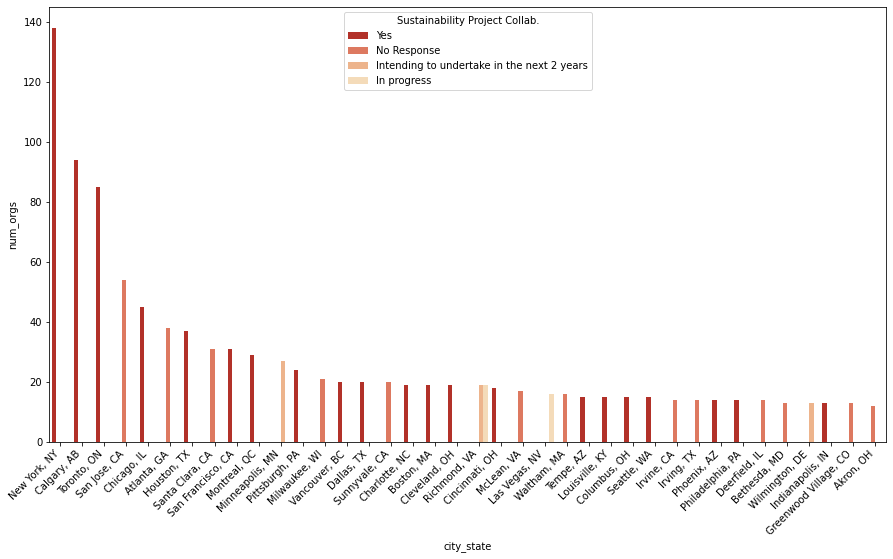

In [46]:
cities_count_50 = cities_count.iloc[0:40,:]
plt.figure(figsize=(15,8));
ax = sns.barplot(
    x="city_state",
    y="num_orgs",
    hue="Sustainability Project Collab.",
    data=cities_count_50,
    palette="OrRd_r"
)

plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium'
);

Spatial plot of cities and organizations

In [47]:
# subset for lat, lng cities data
cities_meta_df = cities_meta_df[['city', 'state_id', 'lat', 'lat', 'lng']]\
  .rename(columns={'city': 'address_city', 'state_id': 'state'})
cities_meta_df.head()

,address_city,state,lat,lat,lng
0,New York,NY,40.6943,40.6943,-73.9249
1,Los Angeles,CA,34.1139,34.1139,-118.4068
2,Chicago,IL,41.8373,41.8373,-87.6862
3,Miami,FL,25.7839,25.7839,-80.2102
4,Dallas,TX,32.7936,32.7936,-96.7662
